In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import cartopy.feature as cfeature
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
from scipy import stats

### functions


In [11]:
def plot_explained_variance(eof_results, n_modes=5):
    """Plot explained variance and cumulative explained variance."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    
    modes = range(1, n_modes + 1)
    ax1.bar(modes, eof_results['explained_variance_ratio'][:n_modes] * 100, color='seagreen')
    ax1.set_xlabel('EOF Mode', fontsize=8)
    ax1.set_ylabel('Explained variance (%)', fontsize=8)
    ax1.set_title('Explained variance by Mode', loc='left', fontsize=8)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.tick_params(labelsize=8)
    ax1.set_ylim(0, 100)
    
    # Cumulative variance plot
    ax2.plot(modes, eof_results['cumulative_variance_ratio'][:n_modes] * 100, 'o-', lw=0.75, ms=2, color='salmon')
    ax2.set_xlabel('EOF Mode', fontsize=8)
    ax2.set_ylabel('Cumulative explained variance (%)', fontsize=8)
    ax2.set_title('Cumulative explained variance', fontsize=8, loc='left')
    ax2.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.5)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.tick_params(labelsize=8)
    ax2.set_ylim(0, 100)

    return fig


def plot_spatial_patterns(eof_results, sst_data, n_modes=4):
    """Plot spatial patterns of the first n_modes."""
    fig = plt.figure(figsize=(15, 4*n_modes))
    proj = ccrs.PlateCarree()
    
    for i in range(n_modes):
        ax = plt.subplot(n_modes, 1, i+1, projection=proj)
        
        im = ax.pcolormesh(sst_data.lon, sst_data.lat,
                          eof_results['spatial_patterns'][i],
                          transform=ccrs.PlateCarree(),
                          cmap='RdBu_r', vmin=-0.006, vmax=0.006)
        
        ax.coastlines()

        gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='lightgray')

        gl.top_labels = False
        gl.right_labels = False
        gl.left_labels = True
        gl.bottom_labels = True
        gl.xlabel_style = {'size': 8}  # Para los labels del eje X (abajo)
        gl.ylabel_style = {'size': 8}  # Para los labels del eje Y (izquierda)

        plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05,
                    label='EOF Pattern')
        
        variance = eof_results['explained_variance_ratio'][i] * 100
        ax.set_title(f'EOF {i+1} ({variance:.1f}% explained variance)', fontsize=8)
        ax.tick_params(labelsize=8)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False) 
        ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', linewidth=0.5, zorder=5)

    return fig

def plot_pc_timeseries(eof_results, time_index, n_modes=4):
    """Plot time series of the first n_modes Principal Components.
    
    Parameters:
    -----------
    eof_results : dict
        Dictionary containing EOF analysis results
    time_index : array-like
        Time index for x-axis (e.g., datetime array)
    n_modes : int, optional
        Number of modes to plot (default: 4)
    """
    fig, axes = plt.subplots(n_modes, 1, figsize=(8, 2*n_modes), sharex=True)
    fig.tight_layout(pad=3.0)
    
    for i in range(n_modes):
        ax = axes[i]
        pc = eof_results['pc_scores'][:, i]
        variance = eof_results['explained_variance_ratio'][i] * 100
        
        ax.plot(time_index, pc, '-', linewidth=0.75, color='darkorange')
        ax.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.5)
        ax.set_ylabel(f'PC {i+1}', fontsize=8)
        ax.set_title(f'Principal Component {i+1} ({variance:.1f}% explained variance)', fontsize=8)
        ax.tick_params(labelsize=8)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    ax.set_xlabel('Time', fontsize=8)
    return fig


def process_and_plot_eof(filepath, variable):
    """Generalized function to load data, perform EOF analysis, and plot results."""
    data = xr.open_dataset(filepath)
    eof_results = perform_eof_analysis(data[variable].values)
    
    fig1 = plot_explained_variance(eof_results)
    fig2 = plot_spatial_patterns(eof_results, data)
    fig3 = plot_pc_timeseries(eof_results, data.time)
    
    return fig1, fig2, fig3

def perform_eof_analysis(data_array, n_components=5):
    """
    Perform EOF analysis on a data array with proper preprocessing
    
    Parameters:
    -----------
    data_array : numpy.ndarray
        Input data array with shape (time, ...) where ... represents spatial dimensions
    n_components : int, optional
        Number of EOF components to compute (default: 5)
        
    Returns:
    --------
    dict containing:
        'pc_scores': Principal component scores
        'pca': Fitted PCA object
        'valid_points': Boolean mask of valid spatial points
        'original_shape': Original shape of input data
        'scaler': Fitted StandardScaler object
        'clean_data': Cleaned data array
    """
    original_shape = data_array.shape
    reshaped_data = data_array.reshape(original_shape[0], -1)
    valid_points = ~np.isnan(reshaped_data).all(axis=0)
    clean_data = reshaped_data[:, valid_points]
    
    for i in range(clean_data.shape[1]):
        column = clean_data[:, i]
        if np.any(np.isnan(column)):
            mean_val = np.nanmean(column)
            clean_data[:, i] = np.where(np.isnan(column), mean_val, column)
    
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(clean_data)
    
    pca = PCA(n_components=n_components)
    pc_scores = pca.fit_transform(scaled_data)
    spatial_patterns = np.zeros((n_components, *original_shape[1:]))
    for i in range(n_components):
        pattern = np.zeros(np.prod(original_shape[1:]))
        pattern[valid_points] = pca.components_[i, :]
        spatial_patterns[i] = pattern.reshape(original_shape[1:])
    
    # Get explained variance ratios
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    
    return {
        'pc_scores': pc_scores,
        'pca': pca,
        'valid_points': valid_points,
        'original_shape': original_shape,
        'scaler': scaler,
        'spatial_patterns': spatial_patterns,
        'explained_variance_ratio': explained_variance_ratio,
        'cumulative_variance_ratio': cumulative_variance_ratio,
        'clean_data': clean_data  # Add this line
    }

def perform_spatial_clustering_eof(eof_results, n_clusters=4):
    """
    Perform K-means clustering on EOF spatial patterns.
    
    Parameters:
    -----------
    eof_results : dict
        Results from perform_eof_analysis
    n_clusters : int, optional
        Number of clusters to identify (default: 4)
        
    Returns:
    --------
    dict containing:
        'clusters': Cluster labels for each spatial point
        'spatial_clusters': Full spatial cluster map
        'valid_mask': Boolean mask of valid points
    """
    # Get the PCA components and valid points
    pca = eof_results['pca']
    valid_points = eof_results['valid_points']
    original_shape = eof_results['original_shape']
    
    # Perform K-means clustering on spatial points using EOFs
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(pca.components_.T)  # Cluster the spatial points
    
    # Create full spatial cluster map
    spatial_clusters = np.full(original_shape[1:], np.nan)
    valid_mask = valid_points.reshape(original_shape[1:])
    spatial_clusters[valid_mask] = clusters
    
    return {
        'clusters': clusters,
        'spatial_clusters': spatial_clusters,
        'valid_mask': valid_mask
    }

def plot_spatial_clusters_eof(cluster_results, data, n_clusters=4):
    """
    Plot spatial patterns of clusters.
    
    Parameters:
    -----------
    cluster_results : dict
        Results from perform_spatial_clustering_eof
    data : xarray.Dataset
        Original data with coordinates
    n_clusters : int
        Number of clusters
    """
    colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))
    custom_cmap = ListedColormap(colors)
    
    plt.figure(figsize=(6, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', linewidth=0.5, zorder=5)
    
    im = ax.pcolormesh(data.lon, data.lat, cluster_results['spatial_clusters'],
                      transform=ccrs.PlateCarree(),
                      cmap=custom_cmap,
                      vmin=-0.5,
                      vmax=n_clusters-0.5)
    
    # Set map extent and ticks
    lon = data['lon']
    lat = data['lat']
    lon_min, lon_max = np.round(lon.min().values * 2) / 2, np.round(lon.max().values * 2) / 2
    lat_min, lat_max = np.round(lat.min().values * 2) / 2, np.round(lat.max().values * 2) / 2
    lon_ticks = np.linspace(lon_min, lon_max, num=min(5, int((lon_max - lon_min) / 0.5) + 1))
    lat_ticks = np.linspace(lat_min, lat_max, num=min(5, int((lat_max - lat_min) / 0.5) + 1))
    
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    
    plt.colorbar(im, label='Cluster', ticks=range(n_clusters))
    return plt.gcf()

def plot_cluster_temporal_patterns(cluster_results, eof_results, time_index):
    """
    Plot temporal patterns for each cluster.
    
    Parameters:
    -----------
    cluster_results : dict
        Results from perform_spatial_clustering_eof
    eof_results : dict
        Results from perform_eof_analysis
    time_index : array-like
        Time index for x-axis
    """
    fig = plt.figure(figsize=(10, 4))
    ax = plt.axes([0.05, 0.05, 0.9, 0.9])
    
    # Get clean data and clusters
    clean_data = eof_results['clean_data']
    clusters = cluster_results['clusters']
    
    # Plot temporal patterns for each cluster
    times = range(len(time_index))
    for i in range(len(np.unique(clusters))):
        cluster_points = clean_data[:, clusters == i]
        cluster_mean = cluster_points.mean(axis=1)
        ax.plot(times, cluster_mean, label=f'Cluster {i}')
    
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Anomaly')
    ax.legend(frameon=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return fig

def compute_monthly_means(filepath, variable):
    """
    Compute monthly means from a netCDF file.
    
    Parameters:
    -----------
    filepath : str
        Path to the netCDF file
    variable : str
        Name of the variable to compute monthly means for
        
    Returns:
    --------
    xarray.Dataset
        Dataset containing monthly means
    """
    data = xr.open_dataset(filepath)
    
    monthly_data = data[variable].resample(time='ME').mean()
    
    monthly_dataset = xr.Dataset(
        data_vars={variable: monthly_data},
        coords=monthly_data.coords
    )
    
    return monthly_dataset

### perform clustering

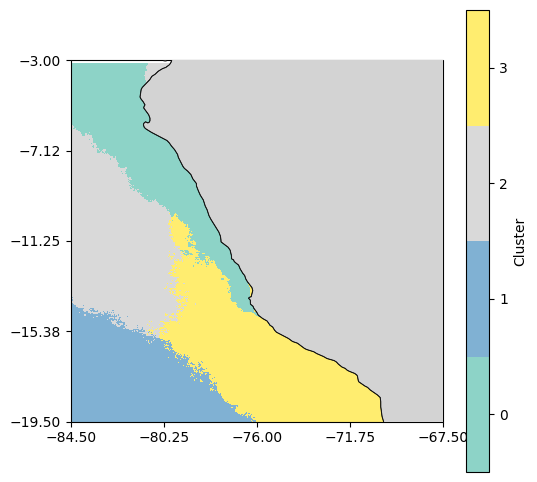

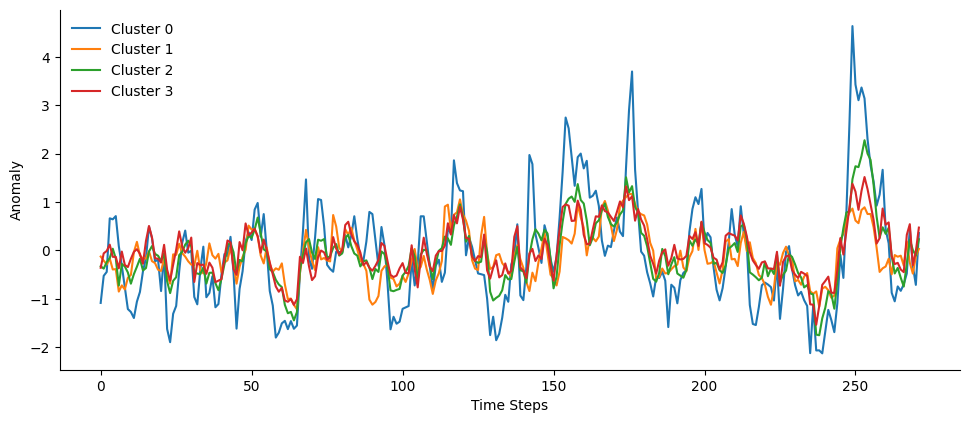

In [49]:
# For SST data
files = [
    '../data/MODIS/processed/sst_anomaly_daily_2002_2025.nc'
]

n_clusters = 4

for file in files:
    data = compute_monthly_means(file, 'sst')
#    data = xr.open_dataset(file)

    eof_results = perform_eof_analysis(data['sst'].values)
    cluster_results = perform_spatial_clustering_eof(eof_results, n_clusters=n_clusters)
    
    fig1 = plot_spatial_clusters_eof(cluster_results, data, n_clusters=n_clusters)
    fig2 = plot_cluster_temporal_patterns(cluster_results, eof_results, data.time)
    
    # fig1 = plot_explained_variance(eof_results)
    # fig2 = plot_spatial_patterns(eof_results, monthly_data)
    # fig3 = plot_pc_timeseries(eof_results, monthly_data.time)
    plt.show()


### load port data